In [1]:
from trajectory_analysis import Trajectory
import json 
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd

In [2]:
files = glob.glob("p*/recording_trial*.json")

In [3]:
lowpass_cutoff = 10 # Hz
dt = 0.005 # tablet event rate

def convert_to_cm(tablet_coordinate, device_range, physical_size_cm):
    device_min, device_max = device_range
    device_span = device_max - device_min
    normalized = (tablet_coordinate - device_min) / device_span
    return normalized * physical_size_cm

def x_to_cm(x): return convert_to_cm(x, [0, 50800], 25.4)    # for Huion 610p tablet
def y_to_cm(y): return convert_to_cm(y, [0, 31750], 15.88)

In [4]:
class Trial:
    def __init__(self, filename, smooth=10, cut=[5,2], filter_order=2, rlim=[0.5, 80]):
        d = json.load(open(filename))
        spl = filename[:-5].split("_")
        self.freq = spl[4]
        self.beta = spl[6]
        self.filename = filename
        self.cursor = pd.DataFrame(d["cursor"])
        self.target = pd.DataFrame(d["target"])
        self.pen    = pd.DataFrame(d["pen"])
        self.pen.xs = self.pen["xs"].apply(x_to_cm)
        self.pen.ys = self.pen["ys"].apply(y_to_cm)
        self.pen.ts = self.pen["ts"]
        

        self.pen_tr = Trajectory(self.pen.xs, self.pen.ys, self.pen.ts, 
                                 dt = 0.005, cut = cut, 
                                 smooth=smooth,
                                 filter_order=filter_order,
                                 )
        self.pen_tr.calc_betas(rlim = rlim)
        

In [5]:
results = [ ]

for f in files:
    trial = Trial(f)
    results.append({"freq"      : trial.freq, 
                    "beta"      : trial.beta, 
                    "pen_betaCV": trial.pen_tr.betaCV,
                    "pen_r2CV"  : trial.pen_tr.r2CV,
                    "pen_betaCA": trial.pen_tr.betaCA,
                    "pen_r2CA"  : trial.pen_tr.r2CA }) 
    

results.sort(key=lambda x: x["freq"])


In [6]:
with open("results.json", "w") as f:
    json.dump(results, f)


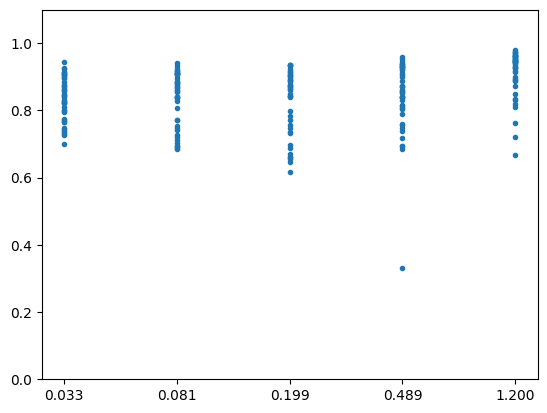

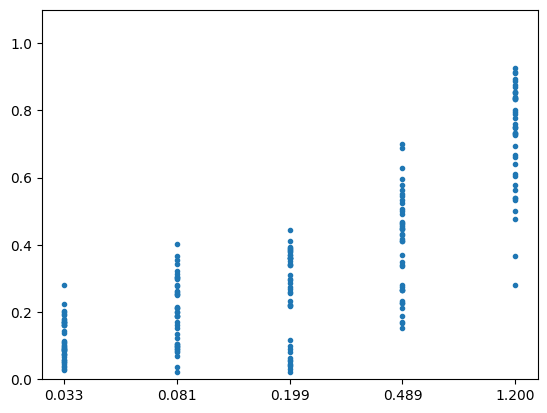

In [7]:

freqs   = [x["freq"]   for x in results]
betaCAs = [x["pen_betaCA"] for x in results]
r2CAs   = [x["pen_r2CA"] for x in results]
betaCVs = [x["pen_betaCV"] for x in results]
r2CVs   = [x["pen_r2CV"] for x in results]

plt.plot(freqs, r2CAs, ".")    
plt.ylim(0,1.1)
plt.show()

plt.plot(freqs, r2CVs, ".")    
plt.ylim(0,1.1)

plt.show()



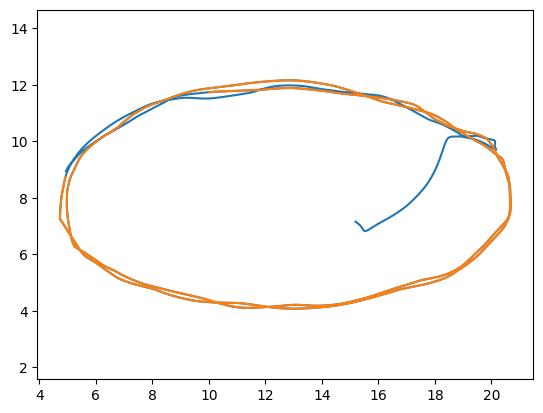

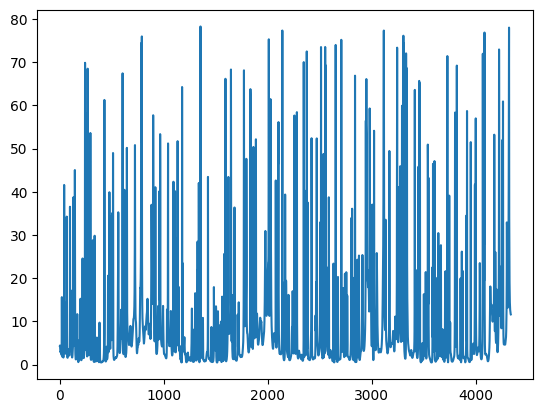

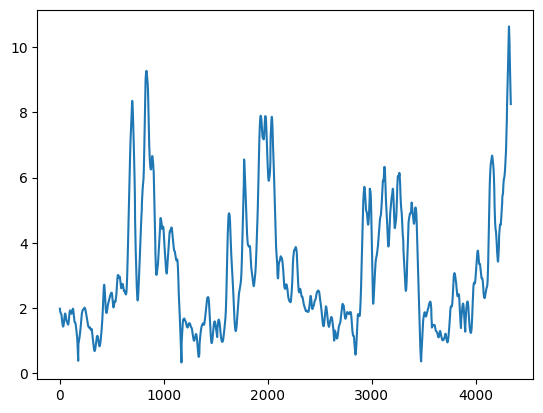

P1\recording_trial_10_freq_0.081_beta_-0.667.json 
 CV: -0.27833559684509607 0.25150703594002677 
 CA 0.7216644031549042 0.6931472472347898


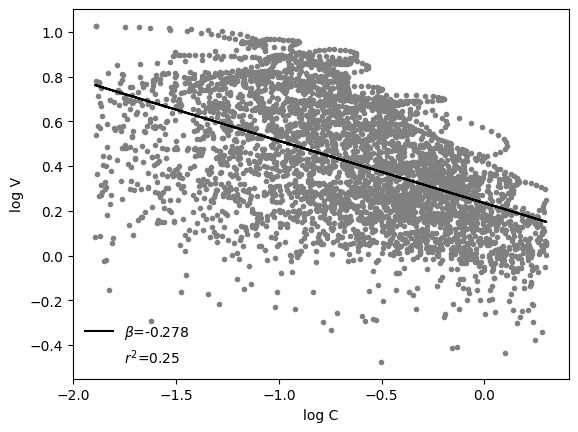

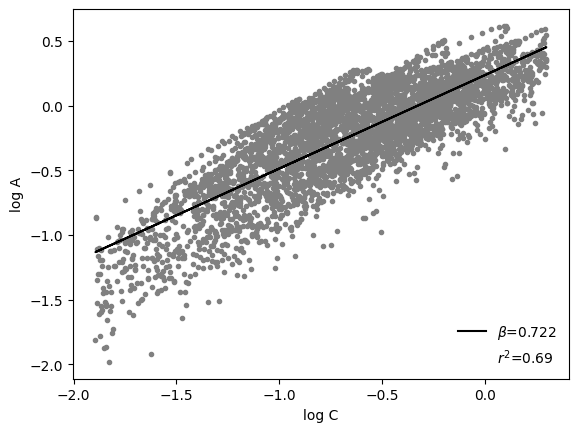

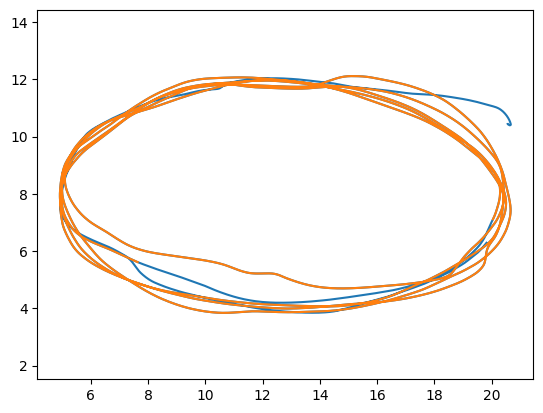

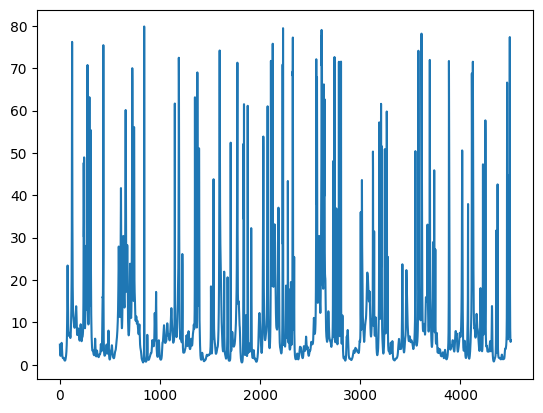

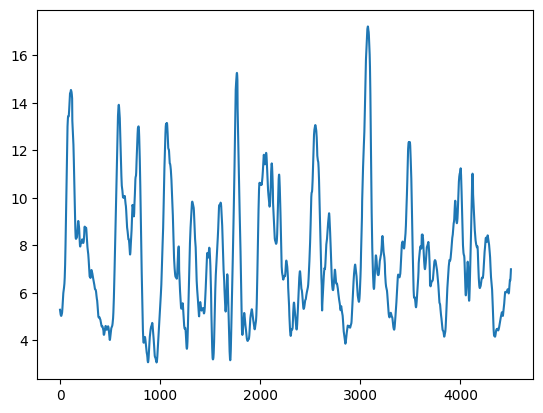

P1\recording_trial_11_freq_0.199_beta_0.000.json 
 CV: -0.17410179472803436 0.23351280721159548 
 CA 0.825898205271965 0.8727040361553134


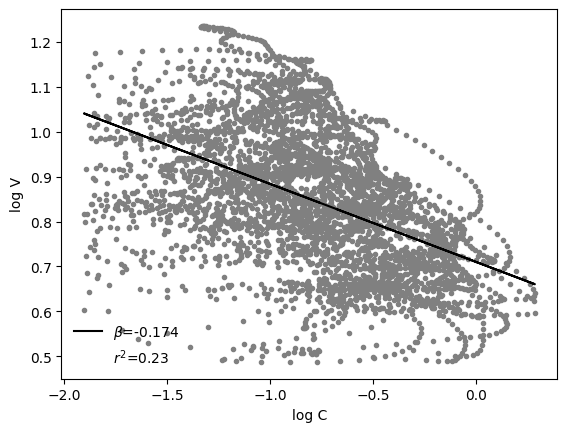

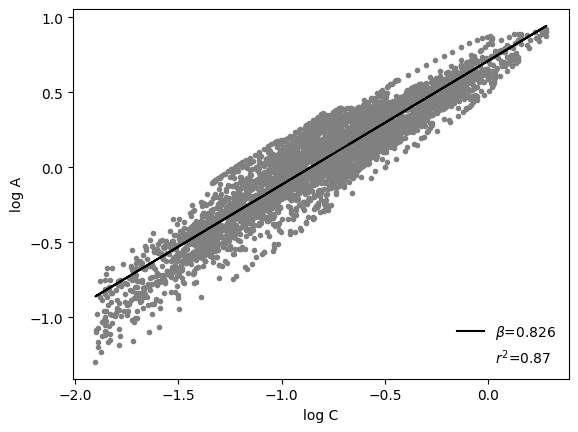

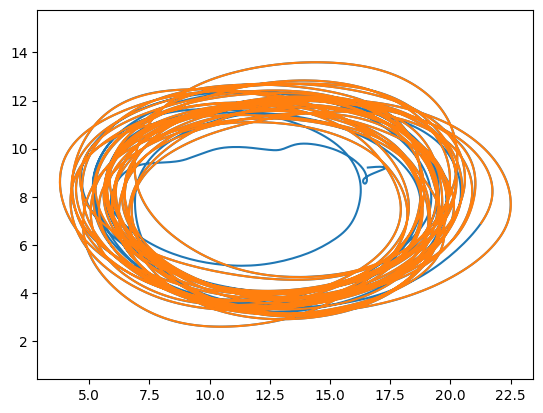

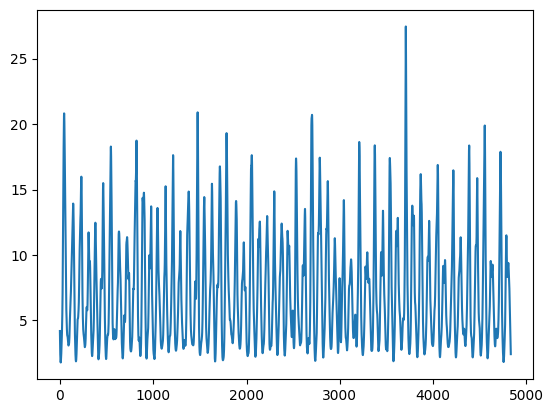

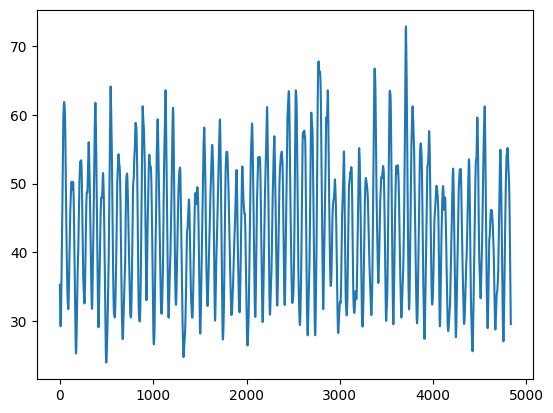

P1\recording_trial_12_freq_1.200_beta_-0.333.json 
 CV: -0.35318489672082487 0.8341391551100273 
 CA 0.6468151032791752 0.9440324578899382


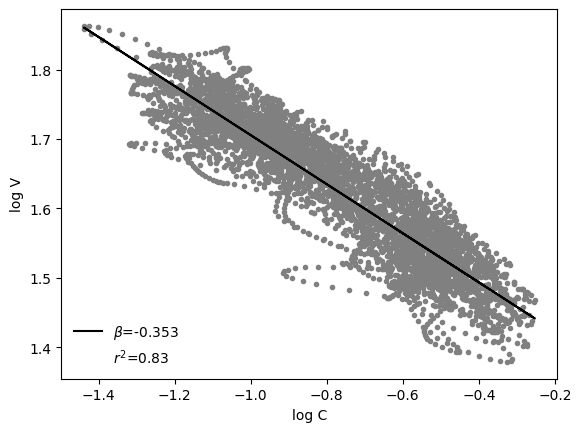

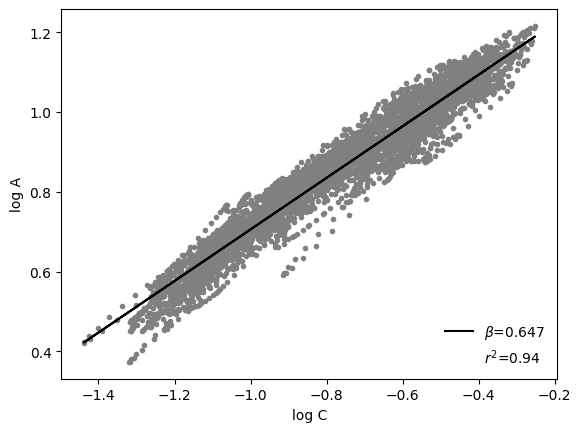

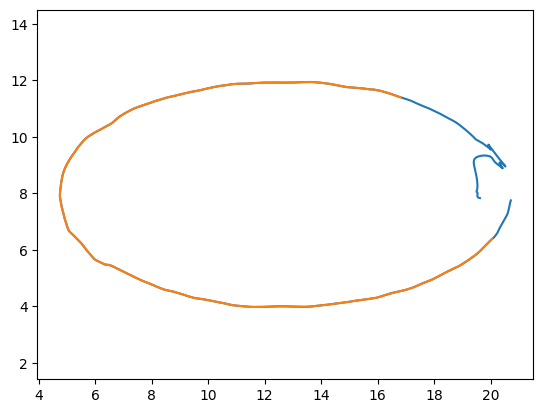

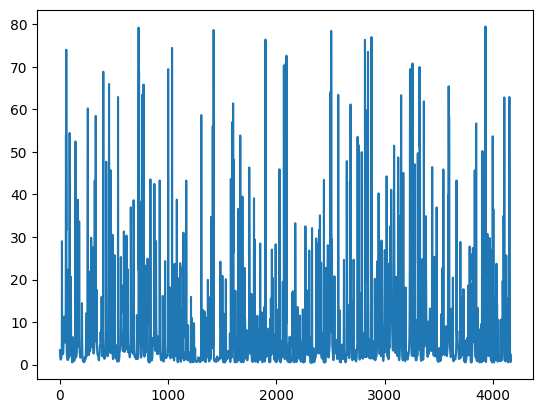

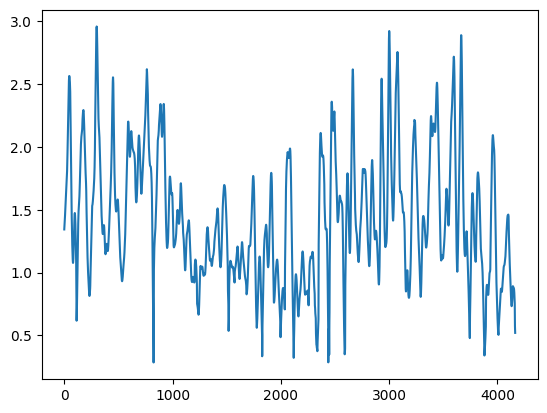

P1\recording_trial_13_freq_0.033_beta_-0.333.json 
 CV: -0.15099226829855353 0.1801435501566725 
 CA 0.8490077317014465 0.8741657119155475


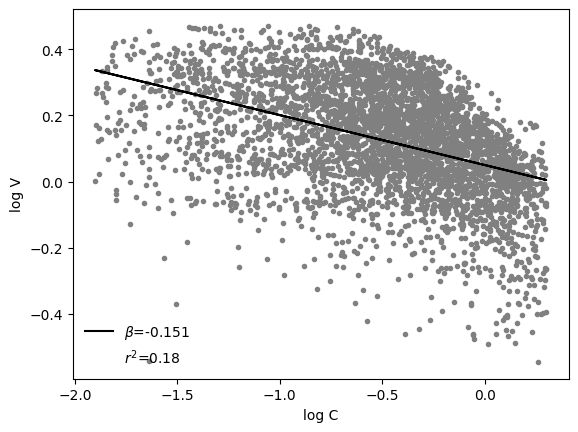

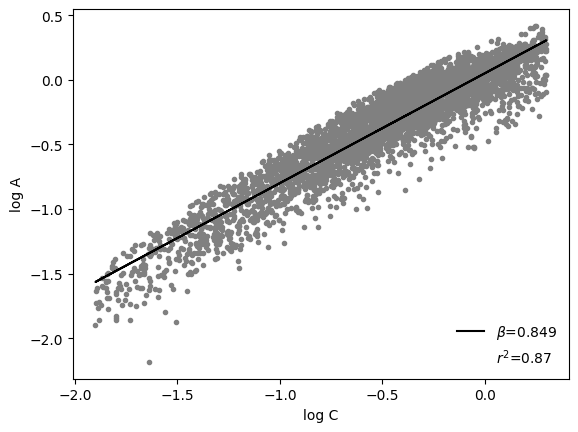

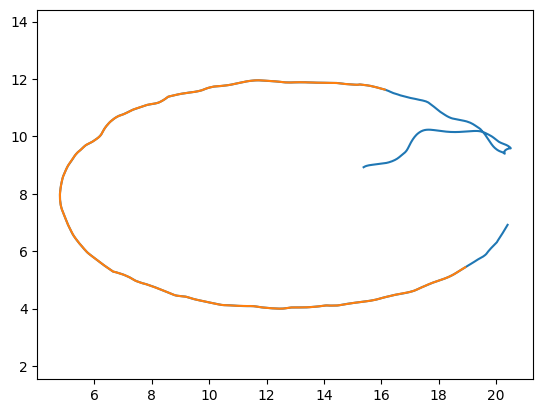

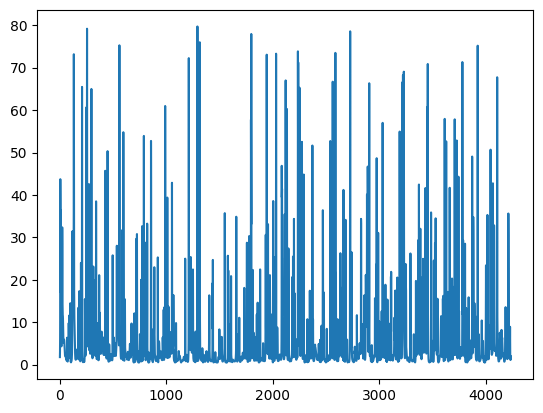

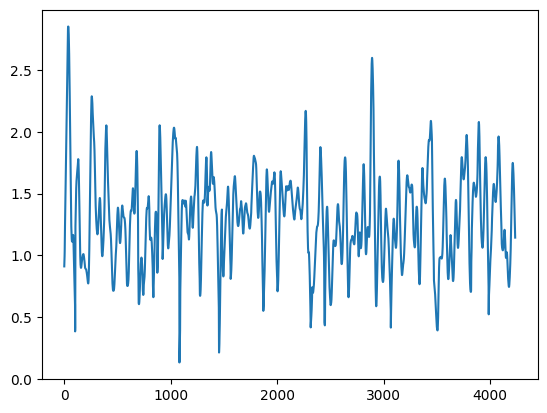

P1\recording_trial_14_freq_0.033_beta_0.000.json 
 CV: -0.09073504457638508 0.08989428850950837 
 CA 0.9092649554236144 0.9084171272813394


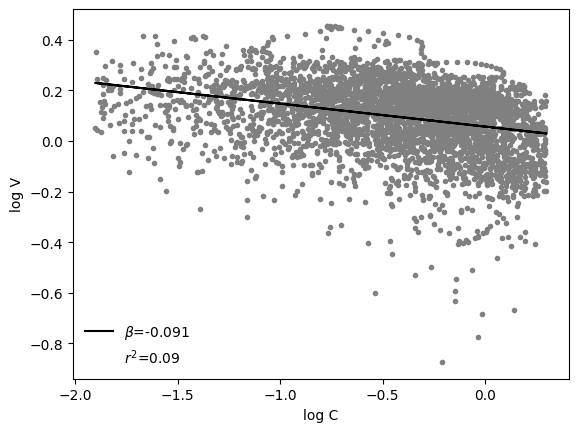

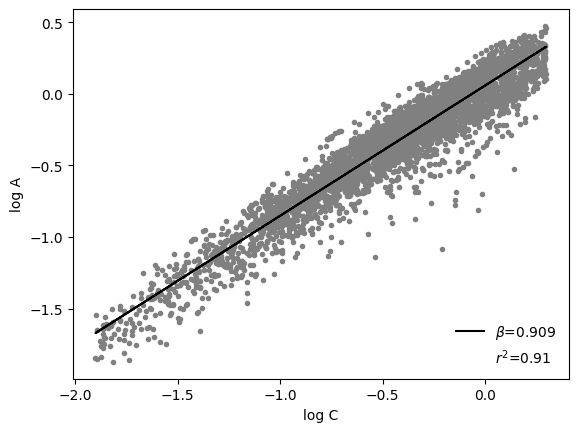

In [8]:
for f in files[:5]:   
    d = Trial(f)
    
    plt.plot(d.pen.xs, d.pen.ys)
    plt.plot(d.pen_tr.x, d.pen_tr.y)
    plt.axis("equal")
    plt.show()
    plt.plot(d.pen_tr.R)
    plt.show()
    plt.plot(d.pen_tr.V)
    plt.show()
    
    print(f, "\n CV:", d.pen_tr.betaCV, d.pen_tr.r2CV, "\n CA", d.pen_tr.betaCA, d.pen_tr.r2CA)
    d.pen_tr.logplotCV()
    d.pen_tr.logplot()
    plt.show()
    

In [12]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 10}
matplotlib.rc('font', **font)



In [9]:
d = Trial(files[115])


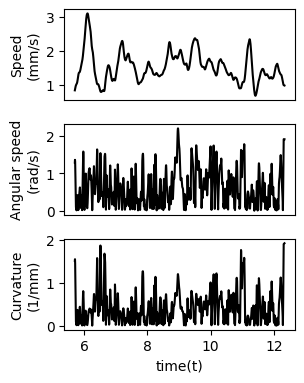

In [10]:

cm = 1/2.54  # centimeters in inches
plt.figure(figsize=[8*cm, 10*cm])
plt.subplot(311)
end = 1300
plt.plot(d.pen_tr.tf[:end], d.pen_tr.V[:end], "k")
plt.ylabel("Speed" "\n" "(mm/s)")
plt.xticks([])
plt.subplot(312)
plt.plot(d.pen_tr.tf[:end], d.pen_tr.A[:end], "k")
plt.ylabel(r"Angular speed" "\n" "(rad/s)")
plt.xticks([])
plt.subplot(313)
plt.plot(d.pen_tr.tf[:end], d.pen_tr.C[:end], "k")
plt.ylabel(r"Curvature" "\n" "(1/mm)")
plt.xlabel("time(t)")
plt.tight_layout()
plt.savefig("../figures/speed_ang_speed_curvature.eps", format="eps")
plt.show()

In [14]:
colors = {
    "green": "#44AA99"
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


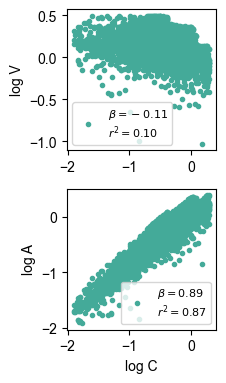

In [15]:
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.figure(figsize=[6*cm, 10*cm])

#plt.title("VC power law")    
plt.subplot(211)
plt.plot(d.pen_tr.logC, d.pen_tr.logV, '.', color=colors["green"], label=fr"$\beta = {d.pen_tr.betaCV:.2f}$" "\n"  fr"$r^2 = {d.pen_tr.r2CV:.2f}$" )    
plt.legend(loc="lower left", prop={'size':8})
plt.ylabel("log V")
plt.subplot(212)
plt.plot(d.pen_tr.logC, d.pen_tr.logA, '.', color=colors["green"], label=fr"$\beta = {d.pen_tr.betaCA:.2f}$" "\n"  fr"$r^2 = {d.pen_tr.r2CA:.2f}$" )
plt.xlabel("log C")
plt.ylabel("log A")

plt.legend(loc="lower right", prop={'size':8})
plt.tight_layout()
plt.savefig("../figures/VC vs AC power law.eps", format="eps")
plt.show()